In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B. 

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [2]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [3]:
using_colab = False

In [4]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## Set-up

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

IOStream.flush timed out


In [2]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Example image

In [113]:
image = cv2.imread('/work/amirkl/DL4CV/end-to-end-chess-recognition/chessReD/images/17/G017_IMG050.jpg')
# Next one - game 17, move 32
# scale_percent = 50 # percent of original size
# width = int(image.shape[1] * scale_percent / 100)
# height = int(image.shape[0] * scale_percent / 100)
# dim = (width, height)
# image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (1024,1024))

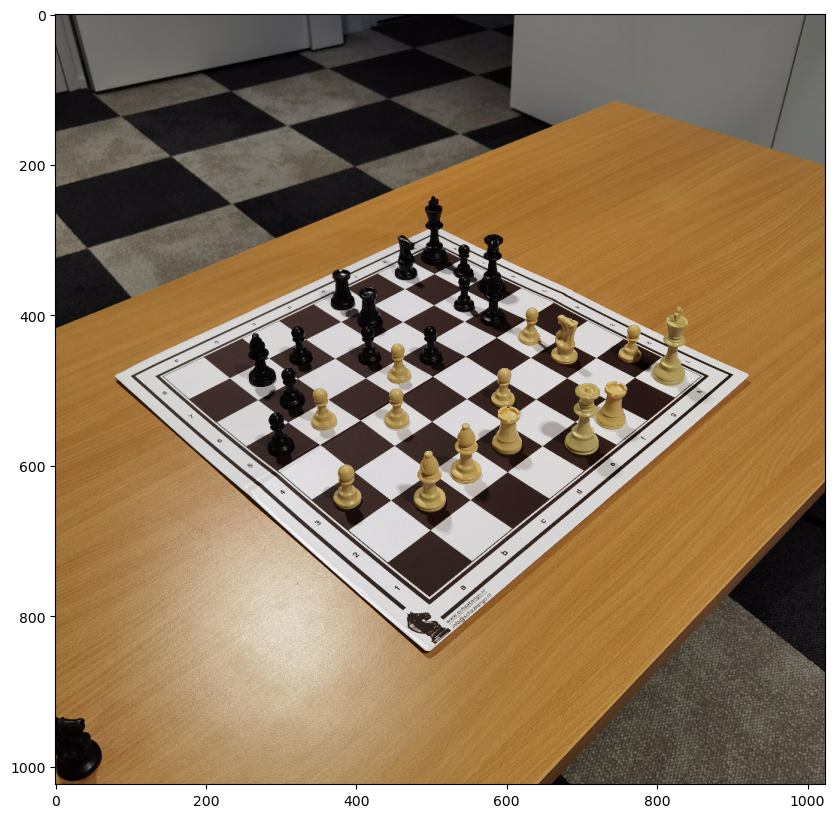

In [114]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [115]:
import os
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = os.path.join('/work/amirkl/DL4CV/segment-anything',"sam_vit_h_4b8939.pth")
model_type = "vit_h"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
print('done') #just to supress the large output of the above line

done


In [137]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=128,
    points_per_batch=32,
    pred_iou_thresh=0.95,
    stability_score_thresh=0.98,
    crop_n_layers=0,
    # crop_n_points_downscale_factor=2,
    box_nms_thresh = 0.85,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

For an image of 800x800 to 1024x1024, 128 point per side give a relatively good result. 256 points is much better, but also takes much longer...

`points_per_batch` affects only how many points are processed at a time. A larger number is faster but requires more memory

The other parameters may be better sine-tuned, but I didn't manage any better than this...

To generate masks, just run `generate` on an image.

In [138]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [139]:
print(len(masks))
# print(masks[0].keys())
# print([mask['bbox'] for mask in masks])
print(masks[0]['segmentation'].shape)

95
(1024, 1024)


Show all the masks overlayed on the image.

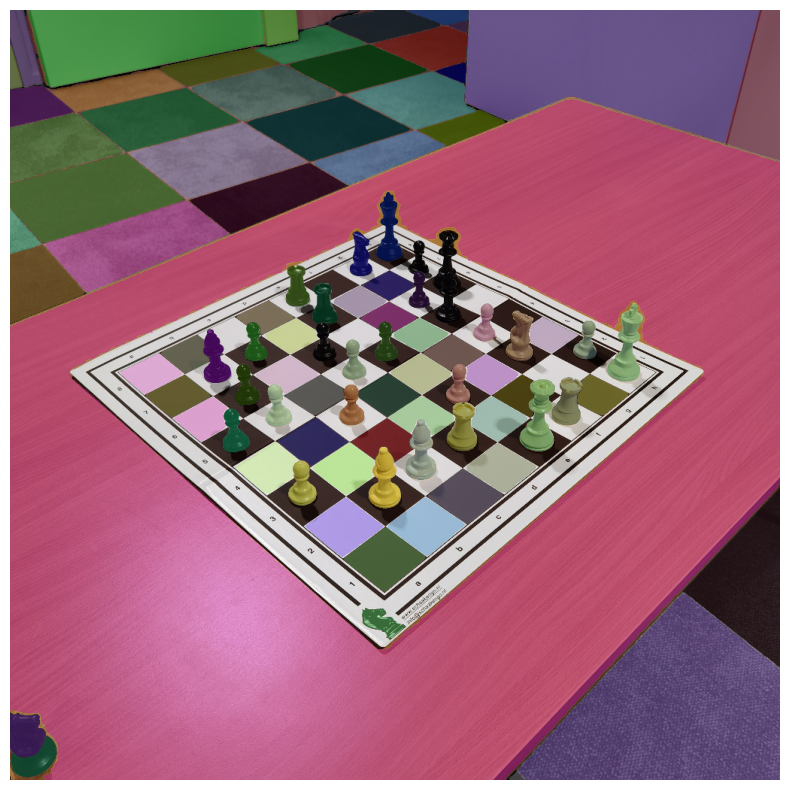

In [140]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 